## Loading data

In [1]:
# 2022 dataset 
import os 
root = '/home/nanaeilish/projects/2023-chemicloud'

if not os.path.exists('data'):
    os.makedirs('data')
    import gdown
    url = 'https://drive.google.com/drive/folders/1zGGIu9atsHdc0ot4v7U-1fMOdaWqpdls?usp=share_link'
    gdown.download_folder(url, quiet=True)
    os.rename(f'{root}/化學雲資料集', 'data')


In [29]:
import pandas as pd 
import glob 
categories = ['災害防治', '環境污染', '毒品', '食品安全', '其他']
data_dir = f'{root}/data'
dfs = {}
for category in categories: 
    filepath = glob.glob(os.path.join(data_dir, f"{category}_ws.csvpkl"))
    df = pd.read_pickle(filepath[0])
    print(category, len(df))
    # clean unwanted columns 
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    # drop duplicates 
    # df.drop_duplicates(inplace = True)
    dfs[category] = df 
    print('after dropping dups:', len(df))

# text length  
# text 文字雲...？ category 文字雲 
# https://tech.havocfuture.tw/blog/python-wordcloud-jieba 



災害防治 128
after dropping dups: 128
環境污染 116
after dropping dups: 116
毒品 169
after dropping dups: 169
食品安全 133
after dropping dups: 133
其他 2066
after dropping dups: 2066


In [3]:
df.iloc[0]

新聞標題                                             跨界儲能 台塑也要當護國神山
新聞內容          因應全球節能減碳趨勢與再生能源、電動車領域快速發展，台塑集團跨入儲能、新能源領域，成立「台塑...
關鍵字                                                         工業用
新聞來源                                                      聯合新聞網
新聞網址                    https://udn.com/news/story/7241/6439162
發布時間                                   2022-07-06T03:57:42.000Z
化學物質詳細資訊      [{"matchno":27399,"casno":"7439-93-2","cname":...
化學物質                                                      ["鋰"]
新聞分類                                                         其他
修正分類                                                         其他
ws_title                   [跨, 界, 儲, 能,  , 台塑, 也, 要, 當, 護國, 神山]
ws_content    [因應, 全球, 節能, 減, 碳, 趨勢, 與, 再生, 能源, 、, 電動車, 領域, ...
Name: 0, dtype: object

In [5]:
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker
ws_driver  = CkipWordSegmenter(model="bert-base") 
ner_driver = CkipNerChunker(model="bert-base", device=0) 

/home/nanaeilish/micromamba/envs/chemicloud/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Word-segmentation

In [19]:
import pandas.api.types as ptypes
# If loading *_ws.csvpkl, skip this cell. 
for cat, df in dfs.items():
    # '新聞標題', '新聞內容', '關鍵字', '新聞來源', '新聞網址', '發布時間', '化學物質詳細資訊',
    # '化學物質', '新聞分類', '修正分類'
    print(cat)
    # make None column to empty string 
    df['新聞標題'].fillna('', inplace = True)
    df['新聞內容'].fillna('', inplace = True)  

    assert ptypes.is_string_dtype(df['新聞標題'])
    assert ptypes.is_string_dtype(df['新聞內容'])

    
    
    titles = df['新聞標題'].tolist() 
    contents = df['新聞內容'].tolist() 
    ws_titles = ws_driver(titles)
    ws_contents = ws_driver(contents) 
    title_char_len = df['新聞標題'].apply(lambda x: len(x)).mean()
    content_char_len = df['新聞內容'].apply(lambda x: len(x)).mean()
    title_word_len = sum([len(x) for x in ws_titles]) / len(ws_titles)
    content_word_len = sum([len(x) for x in ws_contents]) / len(ws_contents)
    df['ws_title'] = ws_titles 
    df['ws_content'] = ws_contents


    print('Average statistics')
    print('title char len:', title_char_len, 'content char len:', content_char_len)
    print('title token len:', title_word_len, 'content token len:', content_word_len)
    
    print()
    

災害防治


Inference: 100%|██████████| 1/1 [00:58<00:00, 58.60s/it]


Average statistics
title char len: 24.0 content char len: 642.4375
title token len: 13.0 content token len: 355.9453125

環境污染


Inference: 100%|██████████| 2/2 [01:13<00:00, 36.54s/it]


Average statistics
title char len: 22.620689655172413 content char len: 955.4741379310345
title token len: 12.543103448275861 content token len: 546.75

毒品


Inference: 100%|██████████| 2/2 [01:20<00:00, 40.37s/it]


Average statistics
title char len: 24.85207100591716 content char len: 657.6627218934912
title token len: 15.449704142011834 content token len: 397.35502958579883

食品安全


Inference: 100%|██████████| 2/2 [01:13<00:00, 36.67s/it]


Average statistics
title char len: 24.481203007518797 content char len: 829.812030075188
title token len: 14.06015037593985 content token len: 471.8421052631579

其他


Inference: 100%|██████████| 22/22 [23:28<00:00, 64.04s/it]


Average statistics
title char len: 23.806389157792836 content char len: 1103.256050338819
title token len: 13.874636979670862 content token len: 639.8165537270087



## Word Cloud

災害防治


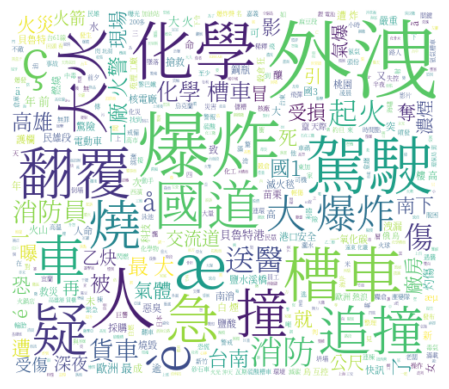

環境污染


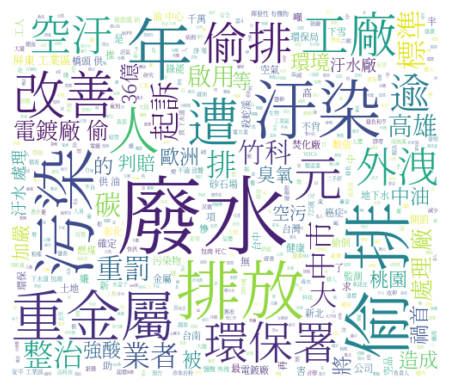

毒品


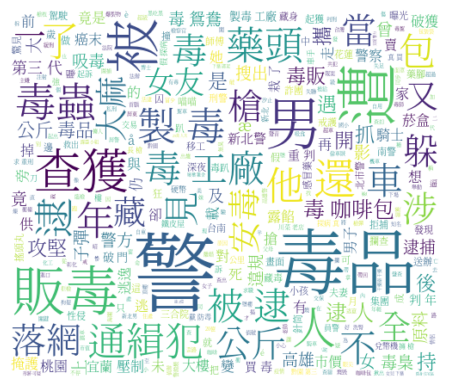

食品安全


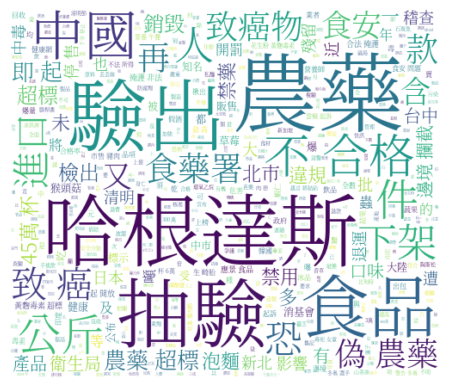

其他


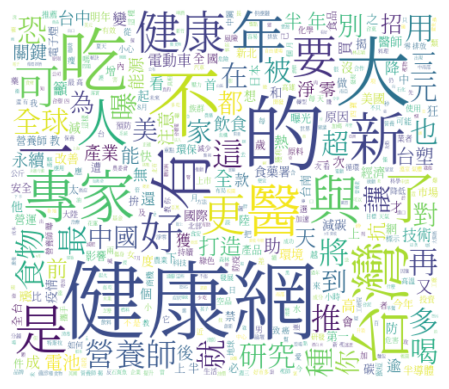

In [4]:
import os
from os import path
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator


font_path = '/home/nanaeilish/projects/2023-chemicloud/fonts/SourceHanSerifK-Light.otf'
wc = WordCloud(font_path=font_path, background_color="white", max_words=500,
               max_font_size=100, random_state=42, width=500, height=430, margin=2,)
for cat, df in dfs.items(): 
    print(cat)
    seg_title = df['ws_title'].tolist()
    all_titles = ' '.join([' 。 '.join(x) for x in seg_title])
    wc.generate(all_titles)
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

## News Date EDA

In [5]:
for cat, df in dfs.items(): 
    data_dir = f'{root}/data/'
    filename = f'{cat}_ws.csvpkl'
    df.to_pickle(os.path.join(data_dir, filename))

In [6]:
# NER these articles 
# 做年份表 

# NER these articles 
# 做年份表 
from typing import List
from collections import defaultdict 


def get_month(date_str:str):
    from datetime import datetime 
    #  ISO-8601 date representation.  
    # format = '%Y-%m-%dT%H:%M:%S.%f%z'
    date_str = date_str.split('T')[0]
    month_str = '-'.join(date_str.split('-')[:-1])
    simple_format = '%Y-%m'
    return datetime.strptime(month_str, simple_format) 

    
dates_dict = defaultdict(lambda :defaultdict(int))  
for cat, df in dfs.items(): 
    dates = df['發布時間'].tolist()
    for date in dates:
        month = get_month(date)
        dates_dict[month][cat] += 1  
dates_df = pd.DataFrame.from_dict(dates_dict, orient='index')



In [25]:
dates_df.sort_index(inplace = True)
dates_df.rename(columns = {
    '災害防治':'disaster prevention', 
    '環境污染':'environmental pollution',
    '毒品':'drugs',
    '食品安全':'food safety',
    '其他':'others',
}, inplace =  True)
dates_df.fillna(0, inplace = True)
dates_df['date'] =dates_df.index.strftime('%Y-%m')
dates_df.set_index('date', inplace = True)
dates_df.head() 


,disaster prevention,environmental pollution,drugs,food safety,others
date,,,,,
2020-01,0.0,2.0,0.0,0.0,23.0
2020-02,1.0,0.0,0.0,0.0,7.0
2020-05,0.0,1.0,0.0,0.0,2.0
2020-06,2.0,0.0,0.0,0.0,2.0
2020-07,1.0,0.0,0.0,0.0,0.0


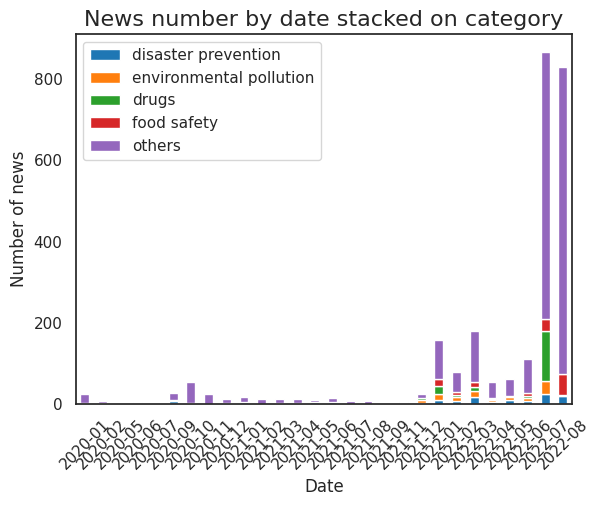

In [38]:

import matplotlib.pyplot as plt
import seaborn as sns
# set seaborn plotting aesthetics
sns.set(style='white')
# create stacked bar chart
dates_df.plot(kind='bar', stacked=True, color=sns.color_palette("tab10")[:5])
# add overall title
plt.title('News number by date stacked on category', fontsize=16)
#a dd axis titles
plt.xlabel('Date')
plt.ylabel('Number of news')

# rotate x-axis labels
plt.xticks(rotation=45)
plt.show()


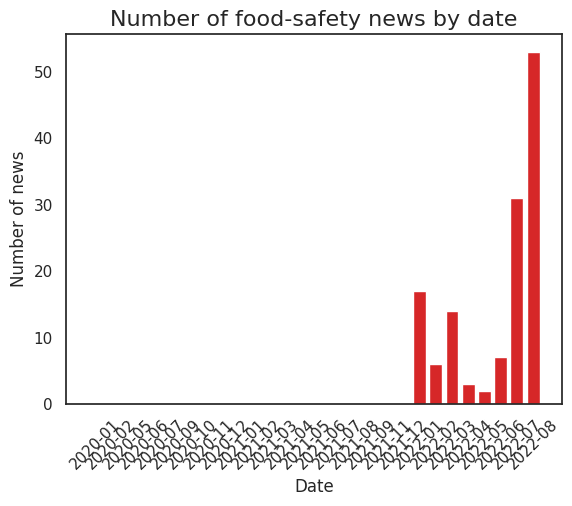

In [39]:

# who v/s fare barplot
plt.bar(dates_df.index, dates_df['food safety'], color='#d62728', label='food safety')

plt.title('Number of food-safety news by date', fontsize=16)
#a dd axis titles
plt.xlabel('Date')
plt.ylabel('Number of news')
# rotate x-axis labels
plt.xticks(rotation=45)
plt.show()